In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from pathlib import Path
import numpy as np
import copy

In [3]:
dir_github = Path(r'D:\RH_local\github').resolve()

dir_analysisFiles = Path(r'D:\RH_local\data\round_6_experiments\mouse_1_19\scanimage_data\20220322\analysis_day0').resolve()

## Directory with F.npy, stat.npy etc.
dir_s2p         = Path(r'D:\RH_local\data\round_6_experiments\mouse_1_19\scanimage_data\20220322\baseline\suite2p\plane0').resolve()

## Path of iscell. Can be from neural net output (iscell_NN)
path_iscell = dir_analysisFiles / 'iscell_NN.npy'

## Directory to save outputs into
dir_save = dir_analysisFiles

In [4]:
import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2

from basic_neural_processing_modules import *

In [5]:
## == IMPORT DATA ==
F = np.load(dir_s2p / 'F.npy') # masks multiplied by data
Fneu = np.load(dir_s2p / 'Fneu.npy') # estimated neuropil signal (Fns = F - Fneu; Fo = ptile(Fns, 30); dFoF=Fns-Fo/Fo)
# iscell = np.load(dir_s2p/'iscell.npy') # probability and bool of each roi
ops = np.load(dir_s2p / 'ops.npy', allow_pickle=True) # parameters for the suite2p
spks_s2p = np.load(dir_s2p / 'spks.npy') # blind deconvolution
stat = np.load(dir_s2p / 'stat.npy', allow_pickle=True) # statistics for individual neurons 

num_frames_S2p = F.shape[1]
Fs = ops[()]['fs']

In [6]:
iscell = np.load(path_iscell)

In [7]:
F_toUse = F[iscell]
Fneu_toUse = Fneu[iscell]

In [8]:
channelOffset_correction = 500
percentile_baseline = 10
neuropil_fraction=0.7

dFoF , dF , F_neuSub , F_baseline = ca2p_preprocessing.make_dFoF(F=F_toUse + channelOffset_correction,
                                                                 Fneu=Fneu_toUse + channelOffset_correction,
                                                                 neuropil_fraction=neuropil_fraction,
                                                                 percentile_baseline=percentile_baseline,
                                                                 multicore_pref=True,
                                                                 verbose=True)
# dFoF_smooth = timeSeries.convolve_along_axis(dFoF,
#                                              kernel=math_functions.gaussian(np.arange(-(Fs)//2, (Fs)//2), 0, sig=50/Fs, plot_pref=True)[0],
#                                              axis=1,mode='same',
#                                              multicore_pref=True,
#                                              verbose=True).astype(np.float32)

dFoF_params = {
    "channelOffset_correction": channelOffset_correction,
    "percentile_baseline": percentile_baseline,
    "neuropil_fraction": neuropil_fraction,
}

Calculated dFoF. Total elapsed time: 6.41 seconds


<IPython.core.display.Javascript object>


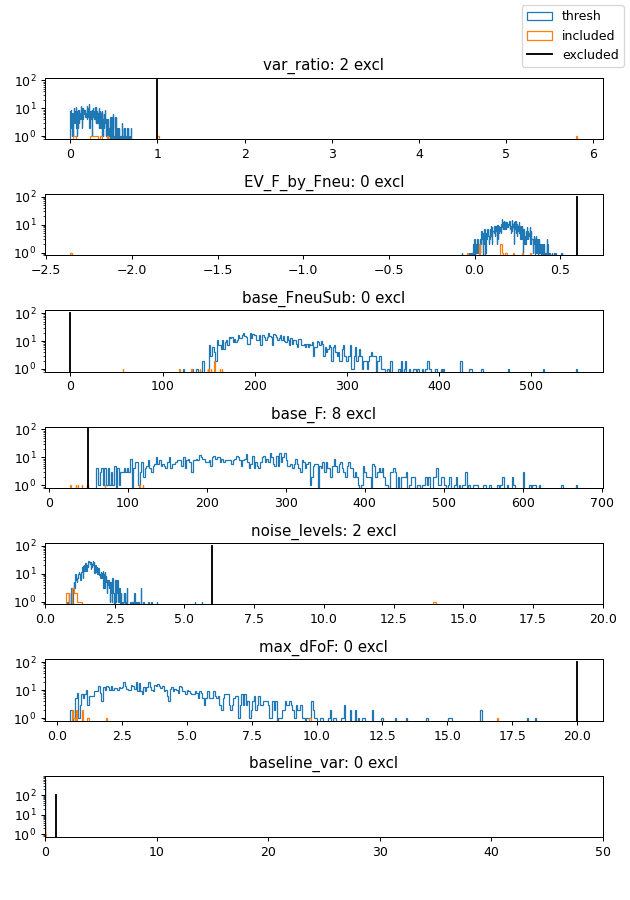

<IPython.core.display.Javascript object>


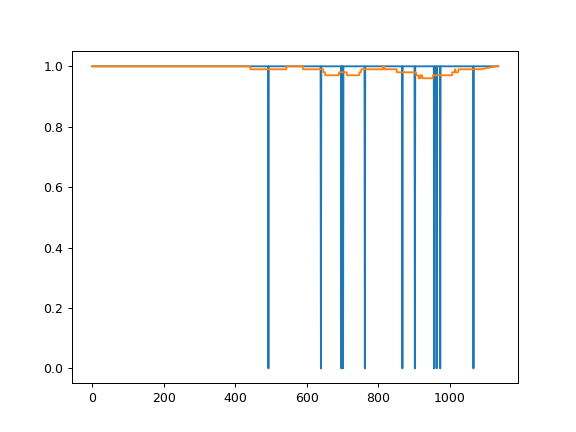

ROIs excluded: 11 / 1137
ROIs included: 1126 / 1137


In [9]:
%matplotlib notebook

thresh = {
            'var_ratio': 1,
            'EV_F_by_Fneu': 0.6,
            'base_FneuSub': 0,
            'base_F': 50,
            'noise_levels': 6,
            'max_dFoF': 20,
            'baseline_var': 1,
        }

# thresh = {
#             'var_ratio': np.inf,
#             'EV_F_by_Fneu': np.inf,
#             'base_FneuSub': -np.inf,
#             'base_F': -np.inf,
#             'noise_levels': 6,
#             'max_dFoF': np.inf,
#             'baseline_var': np.inf,
#         }
    
tqm, iscell_tqm = ca2p_preprocessing.trace_quality_metrics(
    F_toUse,
    Fneu_toUse,
    dFoF,
    dF,
    F_neuSub,
    F_baseline,
    percentile_baseline=percentile_baseline,
    Fs=Fs,
    plot_pref=True,
    thresh=thresh,
)
idxROI_tqm_toInclude = np.where(iscell_tqm)[0]
idxROI_tqm_toExclude = np.where(~iscell_tqm)[0]

In [11]:
iscell_new = copy.copy(iscell)
iscell_new[iscell_new] = iscell_tqm

In [12]:
pickle_helpers.simple_save(
    obj={
        "tqm": tqm,
        "iscell_tqm": iscell_tqm,
        "dFoF_params": dFoF_params
    },
    filename= dir_save / 'trace_quality.pkl'
)

np.save(
    file= dir_save / 'iscell_NN_tqm.npy',
    arr=iscell_new
)